In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [428]:
class EWAlg:
    def __init__(self, epsilon, k, h, myBids, myValue):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myValue = myValue
        self.myBids = myBids
        self.myTotalValue = 0

    def getBids(self):
        return self.myBids

    def getValue(self):
        return self.myValue

    def getTotalValue(self):
        return self.myTotalValue

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        return self.myBids[j.item()]
    
    def update(self, payoffs):
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        self.sumWeights = np.sum(self.weights)
        self.weights = self.weights/self.sumWeights
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return
    
    def invertProbabilitesAndGetAction(self):
        invProbs = 1/self.probs
        invProbs = invProbs/np.sum(invProbs)
        j = np.random.choice(self.k, 1, p = invProbs)
        return self.myBids[j.item()]

    def generatePayoffs(self, bidToBeat, winningBid, meWin):
        if meWin:
            self.myTotalValue += self.myValue - winningBid
        payoffs = np.zeros(self.k)
        for count, bid in enumerate(self.myBids):
            if bid >= bidToBeat:
                payoffs[count] = self.myValue - bid
            else:
                payoffs[count] = 0
        return payoffs
    
    def reset(self):
        self.weights = np.ones(self.k)
        self.payoffs = np.zeros(self.k)
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myTotalValue = 0


# Part 1 : Online Reserve Pricing

In [201]:
class Auction:
    def __init__(self, numItems, k = 100, h = 1, learningRate = 0.1):
        self.k = k
        self.numItems = numItems
        self.possibleReserves = np.linspace(0, h, k)
        self.learner = EWAlg(learningRate, k, h, self.possibleReserves, h)
        self.reserve = self.learner.getAction()

    def getReservePrices(self):
        return self.possibleReserves
    
    def setReservePrice(self, reserve):
        self.reserve = reserve
        return

    def getCurReservePrice(self):
        return self.reserve

    def getLearner(self):
        return self.learner

    def runAuction(self, bids):
        return self.runAuctionHelper(bids, self.numItems, self.reserve), self.reserve
    
    def runAuctionHelper(self, bids, numItemsToSell, reservePrice):
        bids.append(reservePrice)
        bids.sort()
        winningBids = []
        # check if highest bid is greater than reserve price
        if (bids[-(numItemsToSell)] > reservePrice):
            salePrice = bids[-(numItemsToSell+1)]
            for i in range(numItemsToSell):
                winningBids.append(bids[-(i+1)])
            saleRevenue = salePrice * numItemsToSell
            bids.remove(reservePrice)
            return saleRevenue
        else:
            bids.remove(reservePrice)
            numItemsToSell -= 1
            if numItemsToSell == 0:
                # cannot sell any, revenue is 0
                return 0
            return self.runAuctionHelper(bids, numItemsToSell, reservePrice)
        

    def generatePayoffs(self, bids):
        # calculate the payoff for a reserve valuee
        # repeat for all possible reserve values
        payoffs = np.zeros(self.k)
        for count, reserve in enumerate(self.possibleReserves):
            saleRevenue = self.runAuctionHelper(bids, self.numItems, reserve)
            payoffs[count] = saleRevenue
        return payoffs

    
    def updateReservePrice(self, bids):
        payoffs = self.generatePayoffs(bids)
        self.learner.update(payoffs)
        self.reserve = self.learner.getAction()
        return


In [202]:
class Bidders:
    def __init__(self, min, h):
        self.h = h
        self.min = min
    
    def getUniformValue(self):
        return random.uniform(self.min, self.h)
        

In [203]:
def runMultipleAuctions(auctionRounds = 1000, learningRate = 0.1):
    # create an auction and bidders
    numItems = 3
    numBidders = 4
    auction = Auction(numItems, k = 100, h = 1, learningRate = learningRate)
    bidders = []
    for i in range(numBidders):
        bidders.append(Bidders(0, 1))
    # things to keep track of
    allBids = []
    totalRevenue = 0
    avgRevenue = np.zeros(auctionRounds)
    reservePrices = np.zeros(auctionRounds)
    # run the auction
    for i in range(auctionRounds):
        bids = []
        for bidder in bidders:
            bids.append(bidder.getUniformValue())
        allBids.append(bids)    
        curRevenue, reservePrices[i] = auction.runAuction(bids)
        totalRevenue += curRevenue
        avgRevenue[i] = totalRevenue/(i+1)
        auction.updateReservePrice(bids)
    return avgRevenue, reservePrices

In [204]:

def monteCarlo(MCRuns = 500, auctionRounds = 1000, learningRate = 0.1):
    finalReserves = []
    finalAvgRevenue = []
    reservesOverTime = []
    for i in range(MCRuns):
        avgRevenue, reservePrices = runMultipleAuctions(auctionRounds, learningRate)
        finalReserves.append(reservePrices[-1])
        finalAvgRevenue.append(avgRevenue[-1])
        reservesOverTime.append(reservePrices)
    return finalReserves, finalAvgRevenue, reservesOverTime

In [205]:
finalReserves = []
finalAvgRevenues = []
reservesOverTimes = []
epsilons = [2] #[0.0679, 0.1, 0.5, 2]
for epsilon in epsilons:
    finalReserve, finalAvgRevenue, reservesOverTime = monteCarlo(MCRuns = 500, auctionRounds = 1000, learningRate = epsilon)
    finalReserves.append(finalReserve)
    finalAvgRevenues.append(finalAvgRevenue)
    reservesOverTime = np.array(reservesOverTime)
    reservesOverTime = np.mean(reservesOverTime, axis = 0)
    reservesOverTimes.append(reservesOverTime)

In [206]:
print(np.mean(finalReserves))
print(np.mean(finalAvgRevenue))

0.4886262626262627
0.7813984646720943


Our Alg results\

4,3 
0.4886262626262627
0.7813984646720943

4,2
0.47121212121212125
0.7690907908485055

10, 1
0.4893131313131313
0.7730349763357829

10, 3
0.4318181818181819
1.794183521260122

10, 5
0.4247676767676768
2.174732894689363

In [181]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

#for count, epsilon in enumerate(epsilons):
plt.plot(np.arange(1000), reservesOverTimes[count], label = epsilon)

plt.title('Reserves over Time')
plt.xlabel('Rounds')
plt.ylabel('Reserve Price')
plt.legend()
plt.show()

IndexError: list index out of range

<Figure size 800x800 with 0 Axes>

### Calculating Optimals

In [264]:
def findOptRev(numbidders, numItems):
    finalAvgRevenue = np.zeros(500)
    finalAvgReserve = np.zeros(500)
    for j in range(500):
        # create an auction and bidders
        auction = Auction(numItems, k = 100, h = 1, learningRate = 0.5)
        bidders = []
        for i in range(numbidders):
            bidders.append(Bidders(0, 1))
        totalRevenue = np.zeros(100)
        for i in range(1000):
            bids = []
            for bidder in bidders:
                bids.append(bidder.getUniformValue())
            possibleReserves = auction.getReservePrices()
            for count, reserve in enumerate(possibleReserves):
                auction.setReservePrice(reserve)
                payoffs, reserve = auction.runAuction(bids)
                totalRevenue[count] += np.max(payoffs)
        
        optReserve = possibleReserves[np.argmax(totalRevenue)]
        finalAvgReserve[j] = optReserve
        optRevenue = np.max(totalRevenue) / 1000
        finalAvgRevenue[j] = optRevenue
    return finalAvgReserve, finalAvgRevenue

In [154]:
optReserve, optRevenue = findOptRev(4, 2)
finalOptReserve = np.mean(optReserve)
finalOptRevenue = np.mean(optRevenue)
print(finalOptReserve)
print(finalOptRevenue)

0.5012121212121212
0.9029169485672772


Brute Forces Optimals

Distribution U[0,2]
2,1
0.9658383838383838
0.8366969351789084

4,2
0.971959595959596
1.8045542054403818

Uniform Distribution U[0,1]

2,1 
0.5 
5/12

4, 1
0.5034949494949496
0.6144866116272271

4, 2
0.5012121212121212
0.9029169485672772

10, 1
0.5387676767676768
0.8190149684755034

10, 3
0.4981818181818182
1.919048462599637

10, 5
0.49927272727272726
2.3868820821651635

## Part 2

In [453]:
class BrokerUniform:
    def __init__(self, k = 100, h = 1, learningRate = 0.1):
        self.k = k
        self.possibleOffsets = np.linspace(0, h, k)
        self.learner = EWAlg(learningRate, k, h, self.possibleOffsets, h)
        self.offset = self.learner.getAction()

    def getOffsetPrices(self):
        return self.possibleOffsets
    
    def setOffsetPrice(self, offset):
        self.offset = offset
        return
    
    def getOffsetPrice(self):
        return self.offset

    def getLearner(self):
        return self.learner

    def runBroker(self, bids):
        # get the bids from the bidders
        if bids[0] + bids[1] > self.offset:
            payoff = self.offset
            # payoff is the smallest amount the two people could pay and win, 
            # hence it is the payoff in truth telling mechanism
            return payoff, self.offset
        else:
            return 0, self.offset

    def generatePayoffs(self, bids):
        payoffs = np.zeros(self.k)
        for count, offset in enumerate(self.possibleOffsets):
            if bids[0] + bids[1] > offset:
                payoff = offset
                # payoff is the smallest amount the two people could pay and win, 
                # hence it is the payoff in truth telling mechanism
                payoffs[count] = payoff
            else:
                payoffs[count] = 0
        return payoffs
    
    def updateReservePrice(self, bids):
        payoffs = self.generatePayoffs(bids)
        self.learner.update(payoffs)
        self.offset = self.learner.getAction()
        return


In [452]:
class OPTBroker:

    def __init__(self, n, m, x, y):
        self.offset = ((n+m) + (x+y))/2

    def getOffsetPrice(self):
        return self.offset

    def runBroker(self, bids):
        # get the bids from the bidders
        if bids[0] + bids[1] > self.offset:
            # payoff is the smallest amount the two people could pay and win, 
            # hence it is the payoff in truth telling mechanism
            payoff = self.offset
            return payoff
        else:
            return 0 

In [449]:
def runBrokers(auctionRounds = 1000, learningRate = 0.1):

    # create brokers, and parties
    m = 0
    n = 1
    x = 0
    y = 1
    buyer = Bidders(m, n)
    seller = Bidders(x, y)
    ourBroker = BrokerUniform(k = 100, h = 10, learningRate = learningRate)
    optBroker = OPTBroker(n, m, x, y)
    optOffset = optBroker.getOffsetPrice()
    # 
    # things to keep track of
    allBids = []
    totalRevenue = 0
    optRevenue = 0
    avgRevenue = np.zeros(auctionRounds)
    offsetPrices = np.zeros(auctionRounds)
    # run the auction
    for i in range(auctionRounds):
        b1 = buyer.getUniformValue()
        s1 = seller.getUniformValue()
        bids = [b1, s1]
        allBids.append(bids)    
        curRevenue, offsetPrices[i] = ourBroker.runBroker(bids)
        optRevenue += optBroker.runBroker(bids)
        totalRevenue += curRevenue
        avgRevenue[i] = totalRevenue/(i+1)
        ourBroker.updateReservePrice(bids)
    return avgRevenue, offsetPrices, optRevenue/auctionRounds, optOffset

In [446]:

def brokerMonteCarlo(MCRuns = 500, auctionRounds = 1000, learningRate = 0.1):
    finalOffsets = []
    finalAvgRevenues = []
    offsetsOverTime = []
    finalOptAvgRevs = []
    for i in range(MCRuns):
        avgRevenue, offsetPrices, finalOptAvgRev, optOffset = runBrokers(auctionRounds, learningRate)
        finalOffsets.append(offsetPrices[-1])
        finalAvgRevenues.append(avgRevenue[-1])
        offsetsOverTime.append(offsetPrices)
        finalOptAvgRevs.append(finalOptAvgRev)
    finalOffset = np.mean(finalOffsets)
    finalAvgRevenue = np.mean(finalAvgRevenues)
    finalOptAvgRev = np.mean(finalOptAvgRevs)
    return finalOffset, finalAvgRevenue, offsetsOverTime, finalOptAvgRev, optOffset

In [457]:

epsilon = 0.5 #[0.0679, 0.1, 0.5, 2]
finalOffset, finalAvgRevenue, offsetsOverTime, finalOptAvgRev, optOffset = brokerMonteCarlo(MCRuns = 50, auctionRounds = 1000, learningRate = epsilon)
offsetsOverTime = np.array(offsetsOverTime)
offsetsOverTime = np.mean(offsetsOverTime, axis = 0)
print(finalOffset)
print(finalAvgRevenue)
print(optOffset)
print(finalOptAvgRev)


0.8262626262626263
0.4516868686868724
1.0
0.50064


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


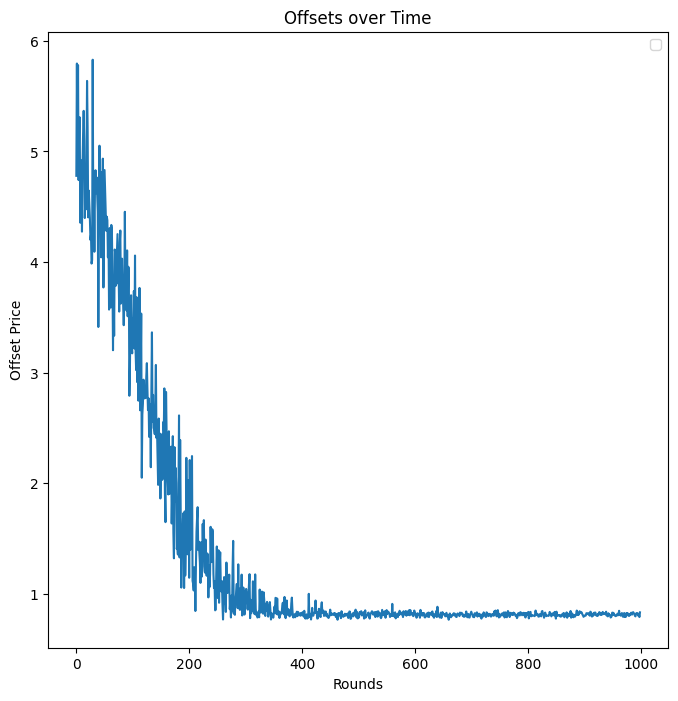

In [456]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

plt.plot(np.arange(offsetsOverTime.size), offsetsOverTime)

plt.title('Offsets over Time')
plt.xlabel('Rounds')
plt.ylabel('Offset Price')
plt.legend()
plt.show()

In [401]:
meeter2_critical_bid = (1 / (0.5 + 1)) * 1.5
meeter1_critical_bid = (0.5 / (0.5 + 1)) * 1.5
print(meeter1_critical_bid + meeter2_critical_bid)

1.5
